In [5]:
import os, math,time
import matplotlib.pyplot as plt
import numpy as np

from silence_tensorflow import silence_tensorflow
silence_tensorflow("ERROR")
import tensorflow as tf
import keras

gpuDevices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpuDevices))
tf.config.experimental.set_memory_growth(gpuDevices[0], True)
tf.config.optimizer.set_experimental_options({'layout_optimizer': False})


import tensorflow_model_optimization as tfmot

Num GPUs Available:  1


In [6]:
batch_size = 32
image_shape = (40,160,1)
code_length = 4
lr=0.001
test_split = 0.2
validation_split=0.1
charset_length = 10
shuff_size =20000
epochs=60

loss_fn = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
train_loss = keras.metrics.Mean(name='train_loss')
train_acc_metric = keras.metrics.CategoricalAccuracy(name='train_accuracy')

In [7]:
def get_shape(ds:tf.data.Dataset):
    for image, label in ds.unbatch().take(1): # type: ignore
        tf.print("image:")
        tf.print(tf.shape(image))
        tf.print(image.dtype)
        tf.print("label:")
        tf.print(tf.shape(label))
        tf.print(label.dtype)
        # print("Single label:", label.numpy())

def decode_one_hot(one_hot_label: tf.Tensor) ->  tf.Tensor:
    one_hot_reshaped = tf.reshape(one_hot_label, [code_length, charset_length])
    digits = tf.argmax(one_hot_reshaped, axis=-1)
    return tf.strings.reduce_join(tf.strings.as_string(digits), axis=0)
    

def decode_one_hot_2dim(one_hot_label : tf.Tensor) ->  tf.RaggedTensor:
    one_hot_reshaped = tf.reshape(one_hot_label, [code_length, charset_length])
    return tf.argmax(one_hot_reshaped, axis=1)


def viz_ds(ds:tf.data.Dataset, count=6):
    plt.figure()
    ds= ds.unbatch().take(count)
    dsit = iter(ds)
    for i in range(count):
        image, label  = next(dsit)  # type: ignore
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image,cmap="gray")
        if (len(label.numpy().shape) == 2):
             plt.title(np.array2string(decode_one_hot_2dim(label).numpy()))
        else:
            plt.title(label.numpy())
            
        plt.tight_layout()
        plt.axis("off")

def get_label(file_path: tf.Tensor):
  parts = tf.strings.split(file_path, os.path.sep)
  return tf.strings.split(parts[-1], ".")[0]

def label_to_one_hot_2d(label:tf.Tensor) -> tf.Tensor:
    digits = tf.strings.to_number(tf.strings.unicode_split(label, 'UTF-8'), out_type=tf.int32)
    one_hot_digits = tf.one_hot(digits, depth=10)
    return one_hot_digits

def decode_img(img: tf.Tensor) -> tf.Tensor:
  return tf.io.decode_image(img,channels=1, dtype=tf.float32, expand_animations = False) # type: ignore

def preprocess_label(label : tf.Tensor) -> tf.Tensor:
  return label_to_one_hot_2d(label)


def configure_for_performance(ds:tf.data.Dataset) -> tf.data.Dataset:
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuff_size)
  ds = ds.batch(batch_size,drop_remainder=True)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

# def preprocess_image(image:tf.Tensor) -> tf.Tensor:
#   # tf.print(tf.shape(image))
#   image = tf.image.resize(image, image_shape[:2])
#   image = tf.image.per_image_standardization(image)
#   return image

def process_path(file_path:tf.Tensor) -> tuple[tf.Tensor,tf.Tensor]:
  label = get_label(file_path)
  # tf.print(label)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, preprocess_label(label)



def create_dataset(folderName: str) -> tf.data.Dataset :
    ds = tf.data.Dataset.list_files(f"{folderName}/*.jpg", shuffle=False)
    
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = configure_for_performance(ds)
    print(ds.cardinality().numpy())
    viz_ds(ds)
    return ds

786


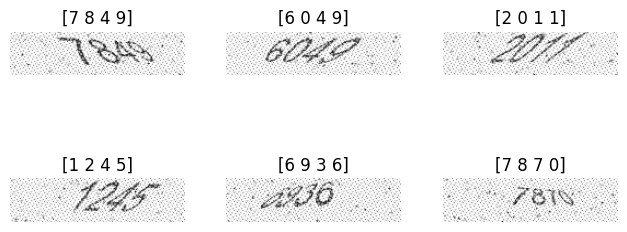

In [8]:
main_ds = create_dataset("/mnt/Data/ML/datasets/captchas-austria")
ds_size = main_ds.cardinality().numpy()
train_ds = main_ds.take(math.floor(ds_size * (1-test_split))) 
test_ds = main_ds.skip(math.floor(ds_size * (1-test_split)))

In [9]:
from common import PerImageStandardizationLayer


loss_fn = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=lr)
train_loss = keras.metrics.Mean(name='train_loss')
train_acc_metric = keras.metrics.CategoricalAccuracy(name='train_accuracy')



def make_encoder() :
    input_layer = keras.layers.Input(shape=image_shape)
    # x = keras.layers.Rescaling(scale=1./255)(input_layer)
    x = PerImageStandardizationLayer()(input_layer)
    # x = input_layer
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    
    x = keras.layers.Flatten(name='flatten_after_convs')(x)
    x = keras.layers.Dense(768, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    output_layer = keras.layers.Dense(code_length * charset_length, activation='softmax')(x)
    output_layer = keras.layers.Reshape((code_length, charset_length), name='final_reshape')(output_layer)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=optimizer, # type: ignore
              loss=loss_fn,
              metrics=[train_acc_metric])
    
    model.summary()
    return model

model = make_encoder()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 160, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ per_image_standardization_layer │ (None, 40, 160, 1)     │             0 │
│ (PerImageStandardizationLayer)  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 40, 160, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 20, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_after_convs (Flatten)   │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 768)            │     9,831,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │        30,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_reshape (Reshape)         │ (None, 4, 10)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,954,600 (37.97 MB)

 Trainable params: 9,954,600 (37.97 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
print(model.input_shape)
print(model.output_shape)
print(model.dtype)

get_shape(train_ds)

(None, 40, 160, 1)
(None, 4, 10)
float32
image:
[40 160 1]
tf.float32
label:
[4 10]
tf.float32


In [11]:
model.fit(train_ds, epochs=epochs)

 15/628 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 2.5530 - train_accuracy: 0.1188 

I0000 00:00:1726315518.734015   38770 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


628/628 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 2.1342 - train_accuracy: 0.2101
Epoch 2/60
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.0205 - train_accuracy: 0.6454
Epoch 3/60
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.5943 - train_accuracy: 0.7934
Epoch 4/60
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.4279 - train_accuracy: 0.8532
Epoch 5/60
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.3319 - train_accuracy: 0.8846
Epoch 6/60
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2734 - train_accuracy: 0.9060
Epoch 7/60
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2315 - train_accuracy: 0.9195
Epoch 8/60
516/628 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1959 - train_accuracy: 0.9329

KeyboardInterrupt: 

In [12]:
def evaluate_model_visual(model, test_dataset:tf.data.Dataset):
    loss, accuracy = model.evaluate(test_dataset)
    
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")
    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)
        
        plt.figure(figsize=(12, 8))  # Adjust figure size for better display
        for i in range(len(images)):
            true_label = labels[i].numpy()
            pred_label = tf.nn.softmax(predictions[i]).numpy()
            
            # Get predicted and true label indices
            pred_label_indices = np.argmax(pred_label, axis=-1)
            true_label_indices = np.argmax(true_label, axis=-1)
            
            # Subplot with 3 images per row
            plt.subplot(len(images) // 3 + 1, 3, i + 1)
            plt.imshow(images[i].numpy().reshape(image_shape[:2]), cmap='gray')
            plt.title(f"True: {true_label_indices}, Pred: {pred_label_indices}")
            plt.axis('off')  # Hide axes for better visualization
        
        plt.tight_layout()
        plt.show()

W0000 00:00:1726315581.515455   38769 assert_op.cc:38] Ignoring Assert operator functional_1/per_image_standardization_layer_1/per_image_standardization/assert_positive/assert_less/Assert/Assert
W0000 00:00:1726315581.515872   38769 assert_op.cc:38] Ignoring Assert operator functional_1/per_image_standardization_layer_1/per_image_standardization/assert_greater_equal/Assert/Assert


158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0563 - train_accuracy: 0.9855
Test Loss: 0.05832663178443909
Test Accuracy: 0.9850672483444214
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


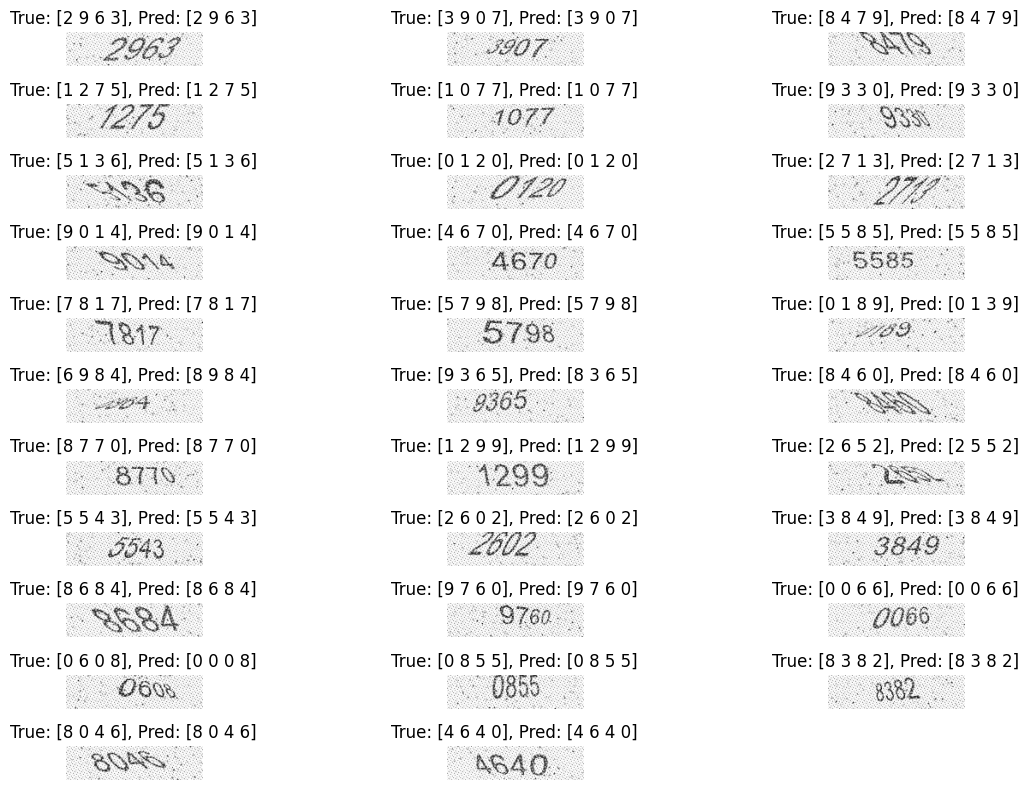

In [13]:
evaluate_model_visual(model, test_ds)

In [15]:
model.save(filepath="mame-undertrained.keras")

In [ ]:
# onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)

In [ ]:
import onnxruntime as ort
def eval_onnx(model : ort.InferenceSession, test_dataset: tf.data.Dataset):
    
    total_time = 0
    correct_predictions = 0 
    total_samples = test_dataset.cardinality().numpy() * batch_size

    for batch_images, batch_labels in test_ds.as_numpy_iterator():
        # print(batch_images.shape)
        start_time = time.process_time()
        outputs = ort_session.run(None, {'image': batch_images})
        end_time = time.process_time()
        total_time += (end_time - start_time)
        for i in range(len(outputs[0])):
            pred = np.argmax(outputs[0][i], axis = 1)
            truth = np.argmax(batch_labels[i], axis = 1)
            if (np.array_equal(pred, truth)):
                correct_predictions+=1
            else :
                print(pred)
                print(truth)
    
    accuracy = correct_predictions / total_samples
    average_inference_time = total_time / total_samples

    print(f"Test DS Accuracy: {accuracy} with {total_samples} samples",)
    print(f"Average Inference Time: {average_inference_time} seconds")

ort_session = ort.InferenceSession('mame.onnx')
eval_onnx(ort_session,test_ds)

In [ ]:
import onnxruntime as ort
import time
import numpy as np
import requests
from io import BytesIO

# Load ONNX model
ort_session = ort.InferenceSession('mame.onnx')
print(ort.get_device())

# Fetch and process image
image_url = "https://appointment.bmeia.gv.at/Captcha?token=3AE8917A00291EA47D06A93A46C50CF1BB34EEB62C1DEE82FB75D1BD8584616F885ED93E88B6CEF0A557F02BFAFB74B5ECE5F75E1F43689F4374736F6F6B79703C2EF50190179B88BDE498815BEE3D15083895B26B9DB710AEB801F13D9BA2AB24B67F31FD233BBDE3CFF6BCFF120852A832BF5100F0B5F747BC8E9883C8C9EFF6D882E75657431733554F49EC60162B0C377C7845735CFCA5DE0B7BFB53F2763542F9FC4AB888A637FD2D9A0DAD6BB9ABD8340A338353F1682C231E38A8BB15D6CC43F30796F714928D4EB55D584C8CF6D00EB5E751BD55A3E6F7B9F1EDD6E9E808CD0BA78D6EE6846EFBED80FA11500CBED9988534F62D83858265899361553A96280443250F2F3DF4252993AD84708862F6BDC346F5A336F27835FB071A4AA9E09A7248E8B447B53C3658EA85DD8C4F24CD80"
response = requests.get(image_url)
image_bytes = BytesIO(response.content)
image = tf.image.decode_image(image_bytes.getvalue(), channels=1)
image = image.numpy()
plt.imshow(image, cmap='gray')
image = np.expand_dims(image, axis=0)
start_time = time.process_time()
outputs = ort_session.run(None, {'image': image})
print(np.argmax(outputs[0][0], axis =1  ))
end_time = time.process_time()

print(end_time-start_time)
